# Introduction: Evaluating the Discount Strategy at Northwind Traders

This project uses data from the Northwind database to answer questions about the (fictitious) Northwind Traders company's discounting strategy. [Microsoft created the Northwind database](https://docs.microsoft.com/en-us/dotnet/framework/data/adonet/sql/linq/downloading-sample-databases) to use as a sample in its Access and SQL Server applications. The database represents internal records for a specialty food import/export business, and it contains tables for customer orders, details on the products themselves, and information about employees and customers, among other things. This project focuses on the data about orders and products.

For this project, I examined the Northwind company's discounting strategy using hypothesis testing. In particular, I wanted to determine what effect (if any) discounts have on the quantities and total dollar values of products that Northwind customers order. 

**Summary of findings** (for more details, see the Interpretations and recommendations section below):

* 10% discounts are ineffective and should be eliminated.
* Discounting correlates with orders that are larger in both quantity and dollar value.
* More research is needed to determine whether discounting is effective in the Beverages category (the largest category by both volume and revenue).

# Extract the data

To start off, I will import the packages I need. Note that I am importing some custom functions for conducting Welch's t-test (`welch_functions`).

In [1]:
# Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

import scipy.stats as stats
import sqlite3

from welch_functions import *

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter("ignore")

The data is stored in a database in the same repository as this notebook. Here I connect to the database:

In [2]:
# Set up connection to the database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

Having looked at the database schema (you can view a diagram in the repo), I know that I want to pull data from a couple of tables at once. The query below takes most of the data from the `OrderDetail` table and joins on some fields about product names and categories from the `Product` and `Category` tables.

In [3]:
# Query the database and load the data
cur.execute("""
    SELECT o.OrderID, o.ProductID, o.UnitPrice, o.Quantity, o.Discount,
        p.ProductName, c.ID AS CategoryID, c.CategoryName
    FROM OrderDetail o
        JOIN Product p
            ON o.ProductID = p.ID
        JOIN Category c
            ON p.CategoryID = c.ID
            ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryID,CategoryName
0,10248,11,14.0,12,0.0,Queso Cabrales,4,Dairy Products
1,10248,42,9.8,10,0.0,Singaporean Hokkien Fried Mee,5,Grains/Cereals
2,10248,72,34.8,5,0.0,Mozzarella di Giovanni,4,Dairy Products
3,10249,14,18.6,9,0.0,Tofu,7,Produce
4,10249,51,42.4,40,0.0,Manjimup Dried Apples,7,Produce


A quick look at the DataFrame above reveals that each row represents an instance of a product in an order. Each `OrderId` can appear more than once (one time for each distinct product in that order). Each `ProductId` can also appear multiple times in the dataset, but a given ID will probably not appear more than once per order (unless, for some reason, a product was purchased at two different prices in the same order, which seems unlikely). 

A product may be assigned more than one unique `UnitPrice` across different orders. The `UnitPrice` field is independent of the `Discount` field&mdash;that is, `UnitPrice` represents the unit price of an item _before_ any discounts are applied.

Before moving on, I want to take a quick look at some summary statistics and value counts.

In [4]:
# View summary statistics
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,4.135499
std,241.378032,22.159019,29.827418,19.022047,0.083450,2.378567
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,2.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,6.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,8.000000


Right away I can see that discounts range from 0 to 25%, and that the ranges of `UnitPrice` and `Quantity` are pretty broad. This could pose problems later on, so I'll keep it in mind.

# Explore and transform the data

First, I will check for missing or placeholder values, especially in the columns I expect to use.

In [5]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
OrderId         2155 non-null int64
ProductId       2155 non-null int64
UnitPrice       2155 non-null float64
Quantity        2155 non-null int64
Discount        2155 non-null float64
ProductName     2155 non-null object
CategoryID      2155 non-null int64
CategoryName    2155 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 134.8+ KB


Good! No missing values, and everything I expected to be a numeric column is in fact numeric. Now to quickly review the existing values in the columns of interest:

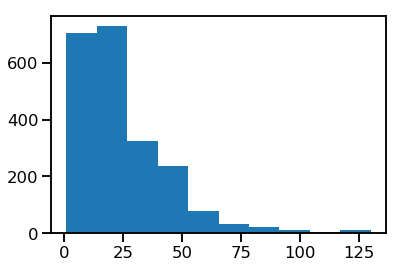

In [6]:
# Plot histogram of `Quantity` values
plt.hist(df.Quantity);

The distribution has a strong positive skew. Later I may remove some outliers to bring it a little closer to normal.

In [7]:
# View `Discount` value counts
print(df.Discount.value_counts())

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64


A few discount levels (1-4%, 6%) seem to be rarely used. I may eliminate these later to focus on the discounts that get used the most.

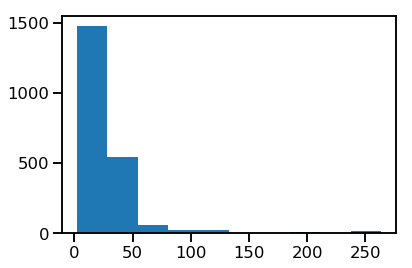

In [8]:
# Plot histogram of `UnitPrice` values
plt.hist(df.UnitPrice);

At this point I can see that there are some extreme values in both `Quantity` and `UnitPrice` that I may want to drop later. There are also some discount values that only occur 1, 2, or 3 times; they will probably need to be dropped as well.

There are a couple of transformations I want to apply to the data before moving any further. 

Knowing that I want to subset the data by whether discounts were applied or not, I will add a boolean column to capture this information (1 = discount applied, 0 = no discount applied).

Then I will add a column that calculates the total price in dollars of a product in an order by multiplying its `UnitPrice` by its `Quantity` by `Discount`, if any. This will let me examine whether discounts increase the total dollar amount customers spend on products or in orders.

In [9]:
# Add a boolean column to help filter discounted from non-discounted items
df['Discount_bool'] = df.apply(lambda row: 1 if row.Discount > 0 else 0, axis=1)

Now I can use the boolean column to calculate the total price in dollars of a product, accounting for a discount if there is one:

In [10]:
# Add a column to calculate the price of a product in an order
df['ProductTotal'] = df.UnitPrice * df.Quantity
for index in df.index:
    if df.loc[index, 'Discount_bool'] != 0:
        df['ProductTotal'] = df.UnitPrice * df.Quantity * (1-df.Discount)

That should do it. Let's take a look:

In [11]:
# View the data
df.head(10)

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryID,CategoryName,Discount_bool,ProductTotal
0,10248,11,14.0,12,0.00,Queso Cabrales,4,Dairy Products,0,168.00
1,10248,42,9.8,10,0.00,Singaporean Hokkien Fried Mee,5,Grains/Cereals,0,98.00
2,10248,72,34.8,5,0.00,Mozzarella di Giovanni,4,Dairy Products,0,174.00
3,10249,14,18.6,9,0.00,Tofu,7,Produce,0,167.40
4,10249,51,42.4,40,0.00,Manjimup Dried Apples,7,Produce,0,1696.00
5,10250,41,7.7,10,0.00,Jack's New England Clam Chowder,8,Seafood,0,77.00
6,10250,51,42.4,35,0.15,Manjimup Dried Apples,7,Produce,1,1261.40
7,10250,65,16.8,15,0.15,Louisiana Fiery Hot Pepper Sauce,2,Condiments,1,214.20
8,10251,22,16.8,6,0.05,Gustaf's Knäckebröd,5,Grains/Cereals,1,95.76
9,10251,57,15.6,15,0.05,Ravioli Angelo,5,Grains/Cereals,1,222.30


To check whether discounts were handled correctly, look at rows 5 and 6, for instance. The `ProductTotal` for row 5 is 77.00 (= 7.7 * 10), and the total for row 6 is 1261.40 (= 42.4 * 35 * (1-0.15)). 

Let's take one last look at summary statistics before moving on:

In [12]:
# Check summary statistics
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID,Discount_bool,ProductTotal
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,4.135499,0.388863,587.374960
std,241.378032,22.159019,29.827418,19.022047,0.083450,2.378567,0.487605,969.224235
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.800000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,2.000000,0.000000,147.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000,0.000000,337.750000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,6.000000,1.000000,656.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,8.000000,1.000000,15810.000000


Since some of my questions have to do with `Quantity`, I want to try applying the Central Limit Theorem to see if the means of many samples randomly drawn from the distribution of `Quantity` values would look like a normal distribution. If so, I can treat `Quantity` in some ways like a normal distribution even though it is heavily right-skewed.

In [13]:
# Get just the `Quantity` values
quantities = df.Quantity

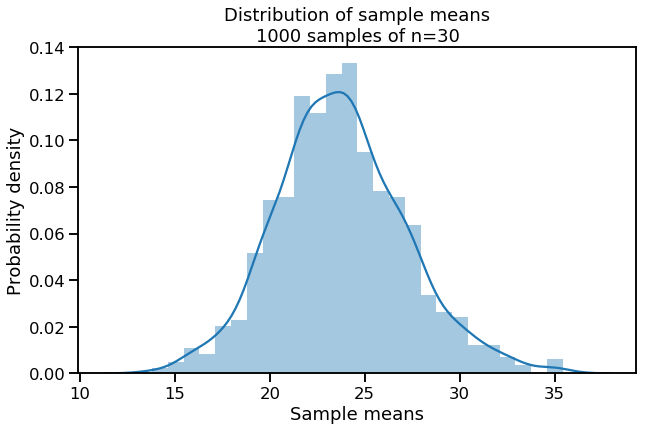

In [14]:
# Plot the means of 1000 samples of size 30
sample_means = []
for n in range(1000):
    sample = np.random.choice(quantities, 30)
    mean = np.mean(sample)
    sample_means.append(mean)

plt.figure(figsize=(10,6))
sns.distplot(sample_means)
plt.xlabel('Sample means')
plt.ylabel('Probability density')
plt.title('Distribution of sample means\n1000 samples of n=30')
plt.show();

Even with the relatively small and arbitrary sample size of 30, that looks normal enough to me. I also think it is reasonable to assume that the observations in the dataset are independent. I don't know whether products were randomly selected for the application of discounts (there was probably some strategy involved), but I will assume that the data passes the assumption of randomness as well.

I will re-check for these assumptions as I manipulate the data for subsequent hypothesis tests.

# Create needed functions

I will use the following functions to make some parts of my analysis more efficient. 

In [15]:
# Define a function to run Welch's t-test, evaluate and print results
def run_welch(a, b, two_sided=False, alpha=0.05):
    """Perform Welch's t-test and compare p-value to given alpha.
       a: first sample (one-dimensional array)
       b: second sample (one-dimensional array)
       two-sided: whether the t-test should be two-sided or not (boolean)
       alpha: alpha value for comparison with calculated p-value
       
       Dependencies: welch_functions.py"""
    
    # Calculate p-value
    p_value = p_value_welch_ttest(a, b, two_sided=False)
    
    # Evaluate and print results
    if p_value < alpha:
        print('Null hypothesis rejected (p_value = {})'.format(p_value))
    else:
        print('Fail to reject null hypothesis (p_value = {})'.format(p_value)) 

In [16]:
# Define a function to calculate Cohen's d
def cohen_d(sample_a, sample_b):
    """Calculate's Cohen's d for two 1-D arrays"""
    
    diff = abs(np.mean(sample_a) - np.mean(sample_b))
    n1 = len(sample_a) 
    n2 = len(sample_b)
    var1 = np.var(sample_a)
    var2 = np.var(sample_b)
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    return d

In [17]:
# Define a function to calculate effect size and power of a statistical test
def size_and_power(sample_a, sample_b, alpha=0.05):
    """Prints raw effect size and power of a statistical test, using 
       Cohen's d (calculated with Satterthwaite approximation)
       Dependencies: Numpy, scipy.stats.TTestIndPower"""
    
    effect = abs(np.mean(sample_a) - np.mean(sample_b))
    print('Raw effect size:', effect)

    d = cohen_d(sample_a, sample_b)
    print('Cohen\'s d:', d)
    power_analysis = TTestIndPower()
    
    sample_length = (len(sample_a) + len(sample_b)) / 2
    power = power_analysis.solve_power(effect_size=d, alpha=alpha, nobs1=sample_length)
        
    print('Power:', power)

# Hypothesis tests

## Hypothesis test 1

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### 1a

Does discount amount have a statistically significant effect on the quantity of a product in an order? 

This test uses the following hypotheses to begin with:

H<sub>0</sub>: mean quantity ordered without discount == mean quantity ordered with discount

H<sub>a</sub>: mean quantity ordered without discount < mean quantity ordered with discount

If discounts are determined to have a significant effect on quantity, then I will re-phrase my hypotheses for subsequent tests to determine which specific discount amounts have significant effects on quantity.

This initial test will be a one-tailed Welch's t-test using the following parameters:

In [18]:
# Set alpha and power
alpha = 0.05
power = 0.8

First I want to check the distribution of quantity values to see if they are normally distributed or if there are outliers that could have a big impact on variance.

#### Inspect the distributions

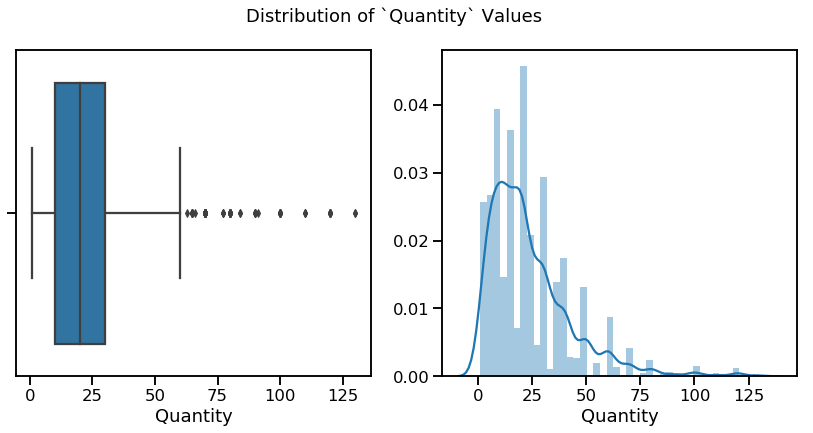

In [19]:
# Create boxplot and distplot for df.Quantity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1 = sns.boxplot(df.Quantity, ax=axes[0])
ax2 = sns.distplot(df.Quantity, ax=axes[1])
plt.suptitle('Distribution of `Quantity` Values', fontsize=18);

The boxplot shows that there are some values lying outside of the whiskers, which represent 1.5 times the interquartile range for this data. The distplot gives another perspective on this positive skew. 

To ensure that outliers are not affecting the results of my analysis, I will drop any observations with `Quantity` values beyond the right whisker.

In [20]:
# Calculate the cutoff point (1.5*IQR + 75th percentile)
iqr = stats.iqr(df.Quantity)
upper_quartile = 30
cutoff = 1.5 * iqr + upper_quartile
cutoff

60.0

In [21]:
# Remove outliers
df_trimmed = df[df.Quantity <= cutoff]
df_trimmed.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID,Discount_bool,ProductTotal
count,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000
mean,10659.126209,40.845745,26.295909,21.290135,0.055073,4.132495,0.379594,532.440782
std,241.028049,22.184800,30.250406,14.329793,0.083188,2.378310,0.485403,900.509713
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.800000
25%,10451.750000,22.000000,12.000000,10.000000,0.000000,2.000000,0.000000,142.500000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000,0.000000,315.000000
75%,10861.000000,60.000000,32.000000,30.000000,0.100000,6.000000,1.000000,608.000000
max,11077.000000,77.000000,263.500000,60.000000,0.250000,8.000000,1.000000,15810.000000


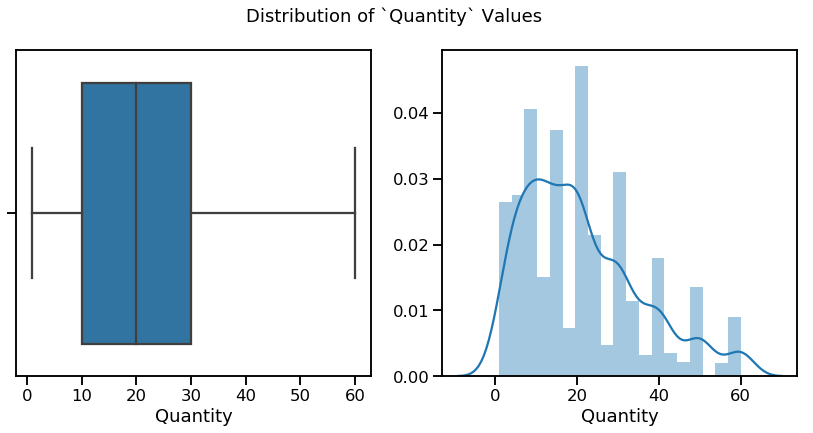

In [22]:
# Create boxplot and distplot for df_trimmed.Quantity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1 = sns.boxplot(df_trimmed.Quantity, ax=axes[0])
ax2 = sns.distplot(df_trimmed.Quantity, ax=axes[1])
plt.suptitle('Distribution of `Quantity` Values', fontsize=18);

I now believe that I have data is that (roughly) normally distributed, independent, and random. Now I will split the data into control (no discount) and experimental (discounted) groups.

In [23]:
# Subset the data based on `Discount` and check the sample lengths
df_no_discount = df_trimmed[df_trimmed.Discount == 0]
df_discount = df_trimmed[df_trimmed.Discount != 0]
print(len(df_no_discount))
print(len(df_discount))

1283
785


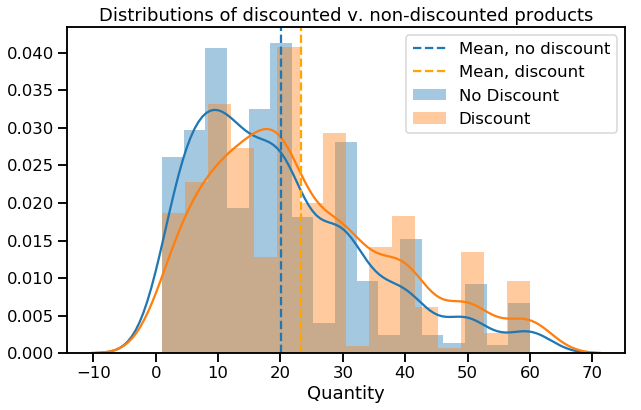

In [24]:
# Visualize the two samples
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity, label='No Discount')
sns.distplot(df_discount.Quantity, label='Discount')
plt.axvline(x=np.mean(df_no_discount.Quantity), linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=np.mean(df_discount.Quantity), linestyle='--', color='orange',
            label='Mean, discount')
plt.legend()
plt.title('Distributions of discounted v. non-discounted products')
plt.show();

A quick [Levene's test](https://en.wikipedia.org/wiki/Levene%27s_test) confirms that the samples have equal variance...

In [25]:
# Compare sample variances (null hypothesis: they are equal)
stats.levene(df_no_discount.Quantity, df_discount.Quantity)

LeveneResult(statistic=2.6481610511325036, pvalue=0.10382224766808272)

...but they are unequal in size. I will use Welch's t-test to determine whether they are significantly different.

#### Run Welch's t-test

In [26]:
# Perform Welch's t-test and print results
run_welch(df_no_discount.Quantity, df_discount.Quantity)

Null hypothesis rejected (p_value = 1.7461160561893507e-07)


The very low p-value tells me that **I can reject the null hypothesis; discounted products are purchased in greater quantities than non-discounted products.**

I can now use Cohen's _d_ to calculate the effect size, which in turn will let me calculate the statistical power of my test given my current alpha, sample sizes, and effect size.

In [27]:
# Calculate effect size and power
size_and_power(df_discount.Quantity, df_no_discount.Quantity)

Raw effect size: 3.3515000173756775
Cohen's d: 0.23546222289162358
Power: 0.9996523011122204


On average, customers ordered 3.35 more of discounted items than non-discounted items, and the statistical test had a power of 0.996, which is well above the minimum of 0.8 that I established earlier. With the very low p-value from the Welch's t-test and the high power, I can feel pretty confident that I have avoided both Type I and Type II errors.

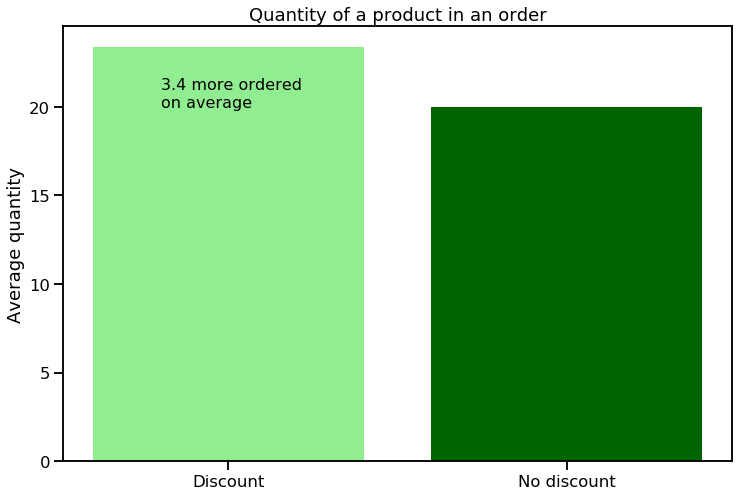

In [28]:
# Visualize difference in average quantity of discounted v. non-discounted
x_values = ['Discount', 'No discount']
y_values = [np.mean(df_discount.Quantity), np.mean(df_no_discount.Quantity)]

plt.figure(figsize=(12,8))
plt.bar(x_values, y_values, color='darkgreen')
plt.bar(x_values[0], y_values[0], color='lightgreen')
plt.text(x=-0.2, y=20, s='3.4 more ordered\non average', fontsize='16')
plt.ylabel('Average quantity')
plt.title('Quantity of a product in an order')
plt.show();

### 1b 

At which discount levels do customers buy more of a product?

If we are going to apply discounts to products, at what discount levels can we expect customers to buy more? To answer this question, I am going to use ANOVA only on the discounted products and use the resulting p-values to determine which discounts have a significant impact on quantity ordered.

For each comparison, the null and alternative hypotheses will be:

H<sub>0</sub>: mean quantity with no discount == mean quantity with discount

H<sub>a</sub>: mean quantity with no discount < mean quantity with discount

Alpha (0.05) and power (0.8) remain the same.

#### Prepare the data

First I will need to create dummy variables for the discount levels I want to evaluate. What are the existing discount levels?

In [29]:
# Check the `Discount` value counts again
df_discount.Discount.value_counts()

0.05    170
0.10    164
0.20    154
0.25    146
0.15    143
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

A few of these discounts look like they rarely get used (1-4%, 6%), so I am going to omit them from my analysis.

In [30]:
# Drop observations with unwanted discount values
df_disc_trimmed = df_discount[(df_discount.Discount == 0.05) | (df_discount.Discount >=0.1)]
df_disc_trimmed.Discount.value_counts()

0.05    170
0.10    164
0.20    154
0.25    146
0.15    143
Name: Discount, dtype: int64

That's better. Now I will create dummy variables for the remaining discounts and attach them to the discounted dataset.

In [31]:
# Create and preview dummy variables for the various discount values
dummies = pd.get_dummies(df_disc_trimmed.Discount, prefix='Discount')
dummies.head()

,Discount_0.05,Discount_0.1,Discount_0.15,Discount_0.2,Discount_0.25
6,0,0,1,0,0
7,0,0,1,0,0
8,1,0,0,0,0
9,1,0,0,0,0
11,1,0,0,0,0


In [32]:
# Rename the columns
dummies.columns = ['Discount5', 'Discount10', 'Discount15',
                  'Discount20', 'Discount25']
dummies.head()

,Discount5,Discount10,Discount15,Discount20,Discount25
6,0,0,1,0,0
7,0,0,1,0,0
8,1,0,0,0,0
9,1,0,0,0,0
11,1,0,0,0,0


In [33]:
# Concatenate the dummy variables to the `df_discount` DataFrame
df_discount_dummies = pd.concat([df_disc_trimmed, dummies], axis=1)
df_discount_dummies.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryID,CategoryName,Discount_bool,ProductTotal,Discount5,Discount10,Discount15,Discount20,Discount25
6,10250,51,42.4,35,0.15,Manjimup Dried Apples,7,Produce,1,1261.40,0,0,1,0,0
7,10250,65,16.8,15,0.15,Louisiana Fiery Hot Pepper Sauce,2,Condiments,1,214.20,0,0,1,0,0
8,10251,22,16.8,6,0.05,Gustaf's Knäckebröd,5,Grains/Cereals,1,95.76,1,0,0,0,0
9,10251,57,15.6,15,0.05,Ravioli Angelo,5,Grains/Cereals,1,222.30,1,0,0,0,0
11,10252,20,64.8,40,0.05,Sir Rodney's Marmalade,3,Confections,1,2462.40,1,0,0,0,0


Now I am ready to run ANOVA to see which discount levels correspond to significantly different quantities ordered.

#### ANOVA

In [34]:
# Run ANOVA
formula = 'Quantity ~ C(Discount5) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'

lm = ols(formula, df_discount_dummies).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount5),2593.482796,1.0,12.026394,5.535697e-04
C(Discount10),758.599225,1.0,3.517746,6.109217e-02
C(Discount15),2611.692448,1.0,12.110835,5.294279e-04
C(Discount20),4686.826179,1.0,21.733562,3.690155e-06
C(Discount25),5464.977040,1.0,25.341972,5.979606e-07
Residual,166481.216621,772.0,NaN,NaN


The ANOVA table shows that we can reject the null hypothesis for all but one discount level: 10\%. A 10% discount does not correspond to increased quantities ordered, but all of the other discount levels do.

Let's see how big the effect sizes are for the other discounts:

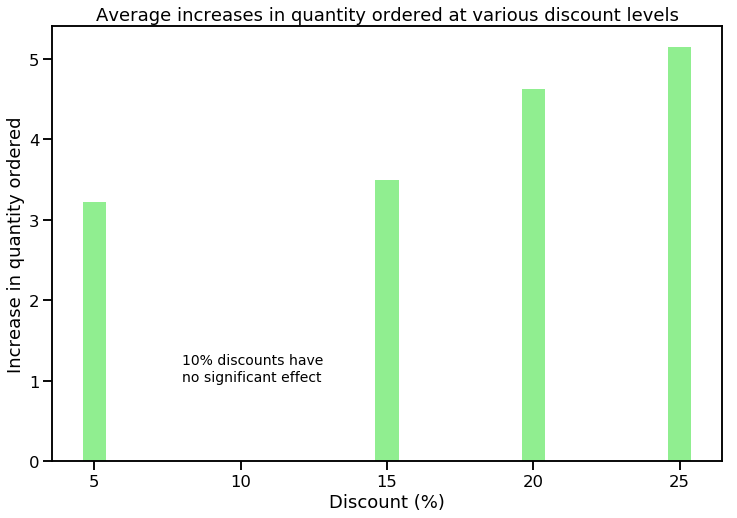

In [35]:
# Get sample means to use in calculating effect sizes
mean_5_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.05]['Quantity'])
mean_10_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.1]['Quantity'])
mean_15_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.15]['Quantity'])
mean_20_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.2]['Quantity'])
mean_25_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.25]['Quantity'])
mean_no_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.0]['Quantity'])

# Organize x-values (discounts) and y-values (effect sizes) for plotting
levels = [5, 10, 15, 20, 25]
means = [mean_5_discount, mean_10_discount, mean_15_discount, mean_20_discount, mean_25_discount]
mean_diffs = [mean - mean_no_discount for mean in means]

# Create a bar plot to show significant effect sizes
plt.figure(figsize=(12, 8))
plt.bar(levels, mean_diffs, color='lightgreen')
plt.bar(x=10, height = mean_10_discount-mean_no_discount, color='white')
plt.xlabel('Discount (%)')
plt.ylabel('Increase in quantity ordered')
plt.title('Average increases in quantity ordered at various discount levels')
plt.text(x=8, y=1, s='10% discounts have\nno significant effect', fontsize=14)
plt.show();

Are these effect sizes big, small, or somewhere in between? And what was the power of the statistical test for each of these? Let's examine each discount in turn.

#### Explore effect sizes and powers

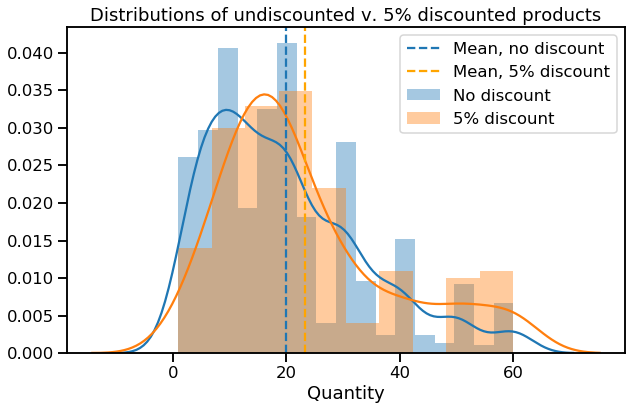

In [36]:
# Compare distributions of non-discounted and 5%-discounted quantities
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity, label='No discount')
sns.distplot(df_discount[df_discount.Discount == 0.05]['Quantity'], 
            label='5% discount')
plt.axvline(x=mean_no_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_5_discount, linestyle='--', color='orange',
            label='Mean, 5% discount')
plt.legend()
plt.title('Distributions of undiscounted v. 5% discounted products')
plt.show();

In [37]:
# Compare sample variances (null hypothesis: they are equal)
stats.levene(df_discount[df_discount.Discount == 0.05]['Quantity'], 
             df_no_discount.Quantity)

LeveneResult(statistic=0.02240733701187282, pvalue=0.8810293663204941)

In [81]:
# Calculate effect size and power
size_and_power(df_discount[df_discount.Discount == 0.05]['Quantity'], 
               df_no_discount.Quantity, alpha=0.01)

Raw effect size: 3.2173673834303784
Cohen's d: 0.22939220917539854
Power: 0.9633680538178738


For 5% discounts, the power is 0.99, well above my chosen threshold of 0.8. As far as Cohen's _d_ values go, this would be considered a small effect.

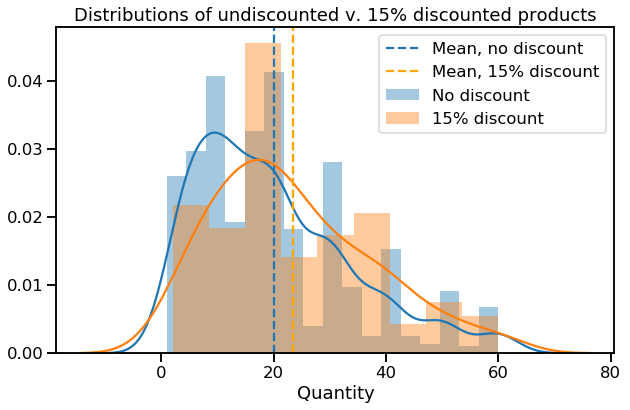

LeveneResult(statistic=0.0693180145704766, pvalue=0.7923704393985946)
Raw effect size: 3.4925627762728304
Cohen's d: 0.251119149378298
Power: 0.9846166372451697


In [82]:
# Do the same for 15% discount
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity, label='No discount')
sns.distplot(df_discount[df_discount.Discount == 0.15]['Quantity'], 
            label='15% discount')
plt.axvline(x=mean_no_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_15_discount, linestyle='--', color='orange',
            label='Mean, 15% discount')
plt.legend()
plt.title('Distributions of undiscounted v. 15% discounted products')
plt.show();

print(stats.levene(df_discount[df_discount.Discount == 0.15]['Quantity'], 
                   df_no_discount.Quantity))

# Calculate effect size and power
size_and_power(df_discount[df_discount.Discount == 0.15]['Quantity'], 
               df_no_discount.Quantity, alpha=0.01)

Power here is well above my threshold of 0.8. There is a low risk of Type II error with 15% discounts. Cohen's _d_ still rates this as a small effect.

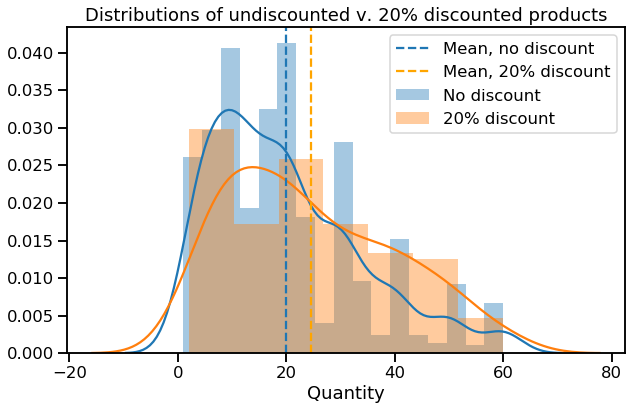

LeveneResult(statistic=4.9602344315708935, pvalue=0.02609132026132316)
Raw effect size: 4.6314239151339684
Cohen's d: 0.3298118450219529
Power: 0.9998778136464106


In [83]:
# Do the same for 20% discount
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity, label='No discount')
sns.distplot(df_discount[df_discount.Discount == 0.2]['Quantity'], 
            label='20% discount')
plt.axvline(x=mean_no_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_20_discount, linestyle='--', color='orange',
            label='Mean, 20% discount')
plt.legend()
plt.title('Distributions of undiscounted v. 20% discounted products')
plt.show();

print(stats.levene(df_discount[df_discount.Discount == 0.2]['Quantity'], 
                   df_no_discount.Quantity))

# Calculate effect size and power
size_and_power(df_discount[df_discount.Discount == 0.2]['Quantity'], 
               df_no_discount.Quantity, alpha=0.01)

Here is the power is very high, meaning that there is essentially no risk of a Type II error in this case. Note that the p-value for Levene's test is below 0.05, meaning that non-discounted and 20%-discounted products do not have the same variance. The formula I used to calculate Cohen's _d_ accounts for different sample variances, so the _d_ value used to calculate power should still be correct.

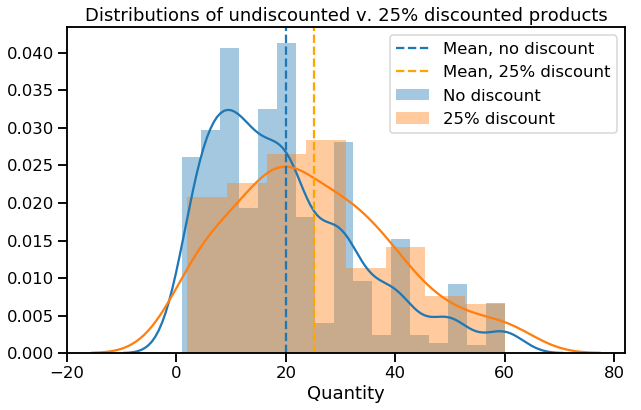

LeveneResult(statistic=2.4127553979598577, pvalue=0.12057210501358487)
Raw effect size: 5.146456827427155
Cohen's d: 0.3675878888140438
Power: 1.0


In [84]:
# Do the same for 25% discount
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity, label='No discount')
sns.distplot(df_discount[df_discount.Discount == 0.25]['Quantity'], 
            label='25% discount')
plt.axvline(x=mean_no_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_25_discount, linestyle='--', color='orange',
            label='Mean, 25% discount')
plt.legend()
plt.title('Distributions of undiscounted v. 25% discounted products')
plt.show();

print(stats.levene(df_discount[df_discount.Discount == 0.25]['Quantity'], 
                   df_no_discount.Quantity))

# Calculate effect size and power
size_and_power(df_discount[df_discount.Discount == 0.25]['Quantity'], 
               df_no_discount.Quantity, alpha=0.01)

This is best outcome of all: for 25%-discounted products, we see the biggest effect size (5 more items ordered) and a power of 1. We can feel confident that 25% discounts really do correspond to customers ordering more of a product, 5 more on average.

Given these outcomes, I would recommend eliminating 10% discounts altogether (or better yet, investigating why they might not be having the intended effect) and perhaps eliminating some of the smaller discount levels to focus on the more effective 20% and 25% discount levels. Without knowing the profit margins for each product, I can't determine the cost effectiveness of these discounts, but if the goal is to increase quantities ordered, these are the better levels to use.

## Hypothesis test 2

When discounts are offered, do customers buy more items overall (not just more of the discounted item)?

In the first hypothesis test above, we examined whether discounts were associated with customers buying more of a product. But this test didn't account for the total quantity of items in an order. When customers receive a discount on some of their items, do they then purchase more items overall? Or do they buy more of the discounted item and then fewer other items to compensate? 

It makes sense that discounting would correspond to increases in overall order size, but if for some reason it <em>didn't</em>, we would want to know so we could investigate further.

For this one-tailed test, the hypotheses will be the following:

H<sub>0</sub>: mean total quantity for orders without discounts == mean total quantity for orders with discounts

H<sub>a</sub>: mean total quantity for orders without discounts < mean total quantity for orders with discounts

Alpha (0.05) and power (0.8) will remain the same.

### Prepare the data

For this test, the data will need to be grouped by order and split into orders where one or more products are discounted and orders where no products are discounted.

The `Discount_bool` column created earlier will come in handy for partitioning the dataset. By grouping by order and then summing the `Discount_bool` column, I can separate orders containing no discounted items (sum = 0) from orders containing one or more discounted items (sum > 0).

In [42]:
# Get list of orders where no items are discounted
group_by_discount_bool = pd.DataFrame(df.groupby('OrderId')['Discount_bool'].sum())
ids_no_disc = group_by_discount_bool[group_by_discount_bool.Discount_bool == 0]
ids_no_disc = list(ids_no_disc.index)

In [43]:
# Get list of orders with at least one discounted item
ids_with_disc = group_by_discount_bool[group_by_discount_bool.Discount_bool > 0]
ids_with_disc = list(ids_with_disc.index)

In [44]:
# Confirm that there is no overlap between the lists of ids
# (Nothing should print)
for item in ids_no_disc:
    if item in ids_with_disc:
        print(item)
        
for item in ids_with_disc:
    if item in ids_no_disc:
        print(item)

In [45]:
# Subset products by whether they occur in orders with discounts or not
orders_discount = df[df.OrderId.isin(ids_with_disc)]
orders_no_discount = df[df.OrderId.isin(ids_no_disc)]

In [46]:
# Group by order; these orders contain ONE OR MORE discounted items
orders_discount = orders_discount.groupby('OrderId')['Quantity'].sum()
print(orders_discount.head())
print('Sample size:', len(orders_discount))

OrderId
10250     60
10251     41
10252    105
10254     57
10258    121
Name: Quantity, dtype: int64
Sample size: 380


In [47]:
# Group by order; these orders contain NO discounted items
orders_no_discount = orders_no_discount.groupby('OrderId')['Quantity'].sum()
print(orders_no_discount.head())
print('Sample size:', len(orders_no_discount))

OrderId
10248     27
10249     49
10253    102
10255    110
10256     27
Name: Quantity, dtype: int64
Sample size: 450


### Inspect the distributions

First, let's visually inspect the distributions:

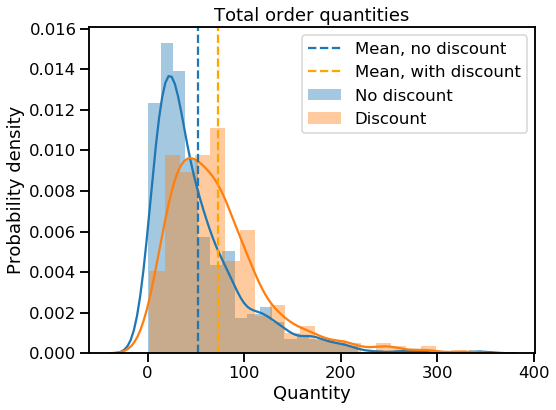

In [48]:
# Create KDE plots of products with and without discounts
plt.figure(figsize=(8,6))
sns.distplot(orders_no_discount, label='No discount')
sns.distplot(orders_discount, label='Discount')
plt.axvline(x=np.mean(orders_no_discount), linestyle='--',
            label='Mean, no discount')
plt.axvline(x=np.mean(orders_discount), linestyle='--', color='orange',
            label='Mean, with discount')
plt.legend()
plt.title('Total order quantities')
plt.ylabel('Probability density')
plt.show();

Both distributions (with and without discounts) appear to be roughly normal, although both are right-skewed. What about their variances?

In [49]:
# Compare sample variances (null hypothesis: they are equal)
stats.levene(orders_no_discount, orders_discount)

LeveneResult(statistic=1.9179524407508215, pvalue=0.16645558467542218)

Levene's test shows that their variances are unequal. I will use a Welch's t-test to determine whether they are different in terms of `Quantity`.

### Perform Welch's t-test

Now I can run a Welch's t-test to compare the total quantities of items in orders with and without discounts to see if they are significantly different.

In [50]:
# Perform Welch's t-test
run_welch(orders_no_discount, orders_discount)

Null hypothesis rejected (p_value = 2.9253389710603983e-09)


In rejecting the null hypothesis, we are finding that when a discount is applied to any item in an order, customers tend to buy more items overall. This is what we hoped to find, and it confirms that discounting is an effective strategy for increasing the quantities of products sold. 

Let's check the effect size and power of this test:

In [51]:
# Calculate effect size and power
size_and_power(orders_discount, orders_no_discount)

Raw effect size: 20.50473684210526
Cohen's d: 0.4127523956142601
Power: 1.0


That's 20.5 more items per order on average when any item in an order has been discounted. Note that this is a bigger effect (_d_=0.41) than the one we saw earlier just for quantities of individual projects, not whole orders (_d_=0.24). 

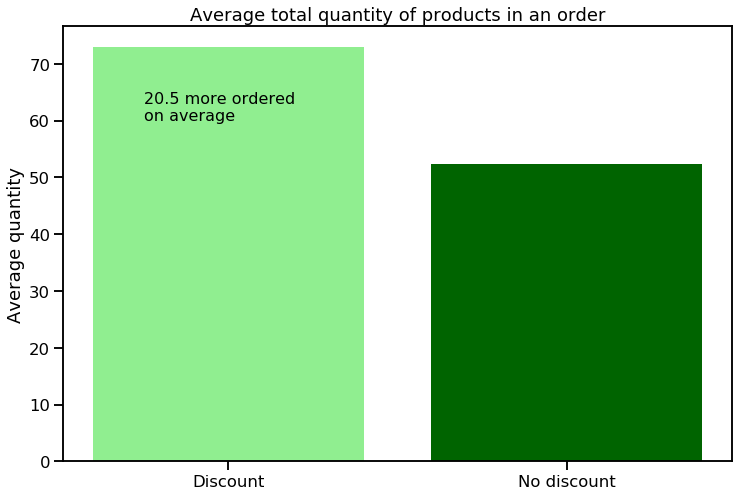

In [52]:
# Create a chart to illustrate the raw effect size
x_values = ['Discount', 'No discount']
y_values = [np.mean(orders_discount), np.mean(orders_no_discount)]

plt.figure(figsize=(12,8))
plt.bar(x_values, y_values, color='darkgreen')
plt.bar(x_values[0], y_values[0], color='lightgreen')
plt.text(x=-0.25, y=60, s='20.5 more ordered\non average', fontsize='16')
plt.ylabel('Average quantity')
plt.title('Average total quantity of products in an order')
plt.show();

## Hypothesis test 3

When discounts are offered, do customers actually spend more per order?

In the previous test we saw that customers tend to buy more items when discounts are offered. What if our goal were not raise sales _volume_ through discounting, but rather sales <em>revenue</em>? Are customers buying discounted items actually spending more? Although that's what we hope, it would be worthwhile to know for certain whether the total dollar amounts of orders with discounts are higher than those without discounts, and by how much.

For this one-tailed Welch's t-test, the hypotheses will be the following:

H<sub>0</sub>: mean total dollar amount of orders without discounts == mean total dollar amount of orders with discounts

H<sub>a</sub>: mean total dollar amount of orders without discounts < mean total dollar amount of orders with discounts

Alpha (0.05) and power (0.8) will remain the same.

### Prepare the data

To prepare the data for analysis, I first need to repeat some steps from the last test to split the data into orders that contain no discounted items and orders that contain one or more discounted items.

In [53]:
# Subset products by whether they occur in orders with discounts or not
orders_discount = df[df.OrderId.isin(ids_with_disc)]
orders_no_discount = df[df.OrderId.isin(ids_no_disc)]

In [54]:
# Group by order; these orders contain ONE OR MORE discounted items
orders_discount = orders_discount.groupby('OrderId')['ProductTotal'].sum()
print(orders_discount.head())
print('Discounted sample size:', len(orders_discount))

OrderId
10250    1552.60
10251     654.06
10252    3597.90
10254     556.62
10258    1614.88
Name: ProductTotal, dtype: float64
Discounted sample size: 380


In [55]:
# Group by order; these orders contain NO discounted items
orders_no_discount = orders_no_discount.groupby('OrderId')['ProductTotal'].sum()
print(orders_no_discount.head())
print('Non-discounted sample size:', len(orders_no_discount))

OrderId
10248     440.0
10249    1863.4
10253    1444.8
10255    2490.5
10256     517.8
Name: ProductTotal, dtype: float64
Non-discounted sample size: 450


This time I have aggregated on the `ProductTotal` column, which contains the unit price times quantity times discount (if any) to equal the price charged for each product in an order. The values in the series `orders_discount` and `orders_no_discount` represent the total dollar value of each order.

### Inspect the distributions

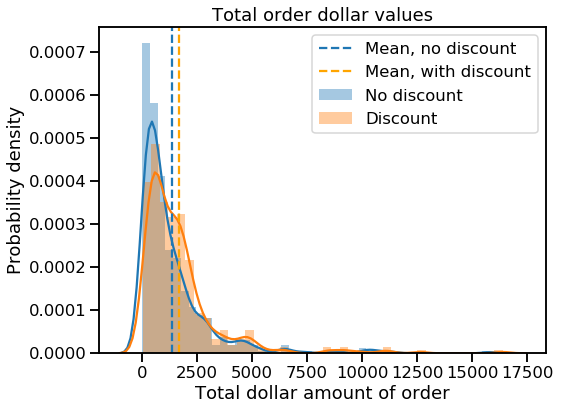

In [56]:
# Create KDE plots of products with and without discounts
plt.figure(figsize=(8,6))
sns.distplot(orders_no_discount, label='No discount')
sns.distplot(orders_discount, label='Discount')
plt.axvline(x=np.mean(orders_no_discount), linestyle='--',
            label='Mean, no discount')
plt.axvline(x=np.mean(orders_discount), linestyle='--', color='orange',
            label='Mean, with discount')
plt.legend()
plt.title('Total order dollar values')
plt.ylabel('Probability density')
plt.xlabel('Total dollar amount of order')
plt.show();

Both distributions (with and without discounts) are strongly right-skewed. Perhaps eliminating some of the extreme values would yield a more normal distribution. 

Let's take another look at `ProductTotal` values:

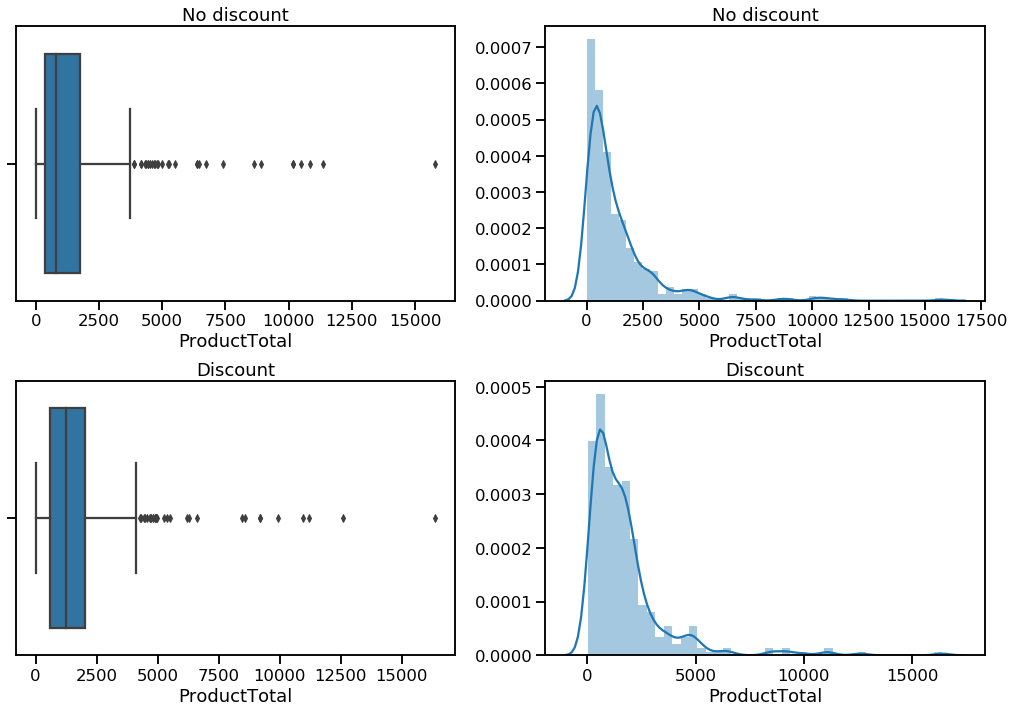

In [57]:
# Create boxplot and distplot for df.Quantity
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax1 = sns.boxplot(orders_no_discount, ax=axes[0][0])
ax1.set_title('No discount')
ax2 = sns.distplot(orders_no_discount, ax=axes[0][1])
ax2.set_title('No discount')
ax3 = sns.boxplot(orders_discount, ax=axes[1][0])
ax3.set_title('Discount')
ax4 = sns.distplot(orders_discount, ax=axes[1][1])
ax4.set_title('Discount')
plt.tight_layout()
plt.show();

Both discounted and non-discounted orders contain some pretty extreme values. I will trim each sample to remove `ProductTotal` values above the right whisker (i.e., remove any value greater than 1.5 * IQR + 75th percentile).

In [58]:
# Calculate the cutoff point (1.5*IQR + 75th percentile) for non-discounted
iqr = stats.iqr(orders_no_discount)
upper_quartile = np.percentile(orders_no_discount, 75)
cutoff = 1.5 * iqr + upper_quartile

# Remove outliers from non-discounted sample
orders_no_disc_trimmed = orders_no_discount[orders_no_discount <= cutoff]
orders_no_disc_trimmed.describe()

count     419.000000
mean      993.723723
std       854.644038
min        12.500000
25%       338.100000
50%       720.000000
75%      1443.650000
max      3740.000000
Name: ProductTotal, dtype: float64

In [59]:
# Calculate the cutoff point (1.5*IQR + 75th percentile) for discounted
iqr = stats.iqr(orders_discount)
upper_quartile = np.percentile(orders_discount, 75)
cutoff = 1.5 * iqr + upper_quartile

# Remove outliers from non-discounted sample
orders_disc_trimmed = orders_discount[orders_discount <= cutoff]
orders_disc_trimmed.describe()

count     351.000000
mean     1280.401038
std       893.300289
min        23.800000
25%       544.993750
50%      1117.800000
75%      1830.268500
max      4109.700000
Name: ProductTotal, dtype: float64

Another quick look at the distributions:

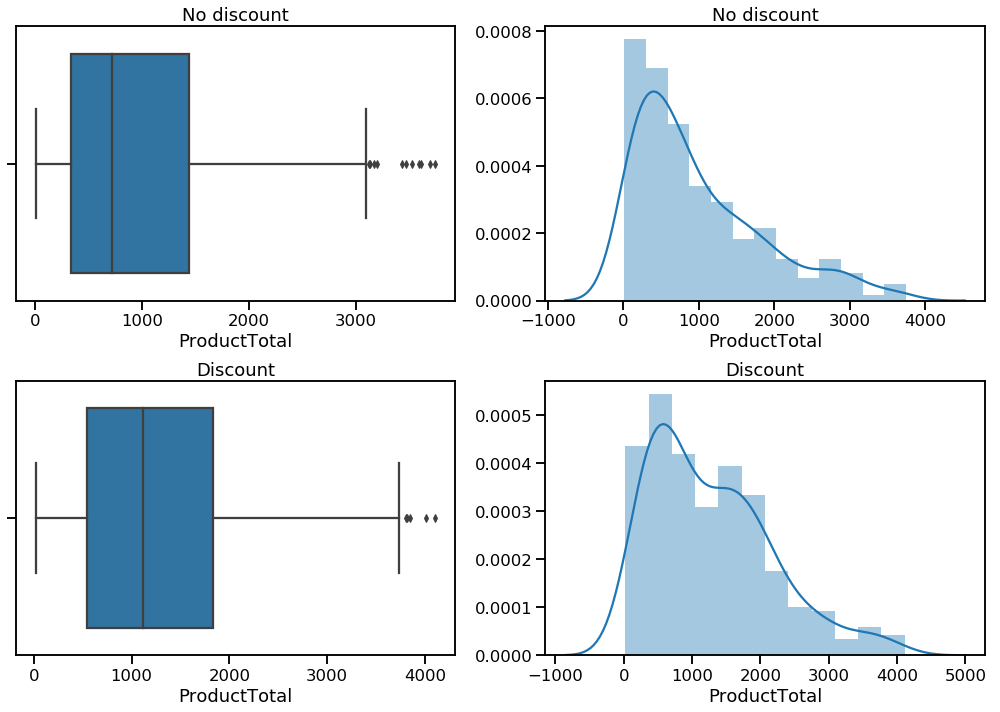

In [60]:
# Create boxplot and distplot for df.Quantity
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax1 = sns.boxplot(orders_no_disc_trimmed, ax=axes[0][0])
ax1.set_title('No discount')
ax2 = sns.distplot(orders_no_disc_trimmed, ax=axes[0][1])
ax2.set_title('No discount')
ax3 = sns.boxplot(orders_disc_trimmed, ax=axes[1][0])
ax3.set_title('Discount')
ax4 = sns.distplot(orders_disc_trimmed, ax=axes[1][1])
ax4.set_title('Discount')
plt.tight_layout()
plt.show();

That's better. There is still some positive skew, but it is less extreme. What about the two samples' variances?

In [61]:
# Compare sample variances (null hypothesis: they are equal)
stats.levene(orders_no_disc_trimmed, orders_disc_trimmed)

LeveneResult(statistic=2.8820699541680326, pvalue=0.08997592697247588)

Levene's test shows that the variances are the same. Since the two samples are of different sizes, I will use a Welch's t-test to determine whether they are different in terms of `ProductTotal`.

Before proceeding, I should check that the mean total dollar values of orders, when sampled many times, form a normal distribution.

In [62]:
# Get a list of all orders' total quantities
all_orders = pd.concat([orders_disc_trimmed, orders_no_disc_trimmed])
print(all_orders[:10])
print(len(all_orders))

OrderId
10250    1552.600
10251     654.060
10252    3597.900
10254     556.620
10258    1614.880
10260    1504.650
10262     584.000
10263    1873.800
10264     695.625
10266     346.560
Name: ProductTotal, dtype: float64
770


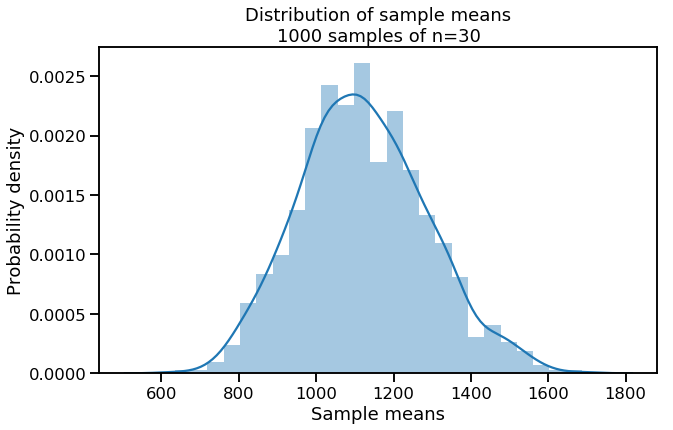

In [63]:
# Plot the means of 1000 samples of size 30
sample_means = []
for n in range(1000):
    sample = np.random.choice(all_orders, 30)
    mean = np.mean(sample)
    sample_means.append(mean)

plt.figure(figsize=(10,6))
sns.distplot(sample_means)
plt.xlabel('Sample means')
plt.ylabel('Probability density')
plt.title('Distribution of sample means\n1000 samples of n=30')
plt.show();

That looks pretty normal. I will assume that the data are independent and reasonably random as well.

### Perform Welch's t-test

Now I can run a Welch's t-test to determine whether there is a significant difference between the mean total dollar amounts of orders with and without discounts.

In [64]:
# Perform Welch's t-test and print the results
run_welch(orders_no_disc_trimmed, orders_disc_trimmed)

Null hypothesis rejected (p_value = 3.5499868635824328e-06)


The results of the t-test indicate that we can reject the null hypothesis; there is indeed a significant difference between the mean total dollar amounts of orders with and without discounts.

How big is that difference? And how powerful was the test?

In [65]:
# Calculate effect size and power
size_and_power(orders_disc_trimmed, orders_no_disc_trimmed)

Raw effect size: 286.67731531118056
Cohen's d: 0.32900762074453443
Power: 0.9953267808989196


Orders with discounts amount to \\$287 more on average than orders without discounts. This calculation does not account for the value of discounts in an order, just their presence. For instance, some orders may include only items with large discounts, while other orders may have many non-discounted items and only one item discounted at a low value (e.g., 5\%). This calculation tells us, however, that orders including at least one discounted item can bring in over $280 more in gross revenue on average than orders where no item has been discounted. 

Having seen these results, I would reiterate my recommendation from the previous test. Getting a discounted item into every shopping cart should be a priority, and the most convenient way to do that may be to offer small discounts year-round on the most popular items.

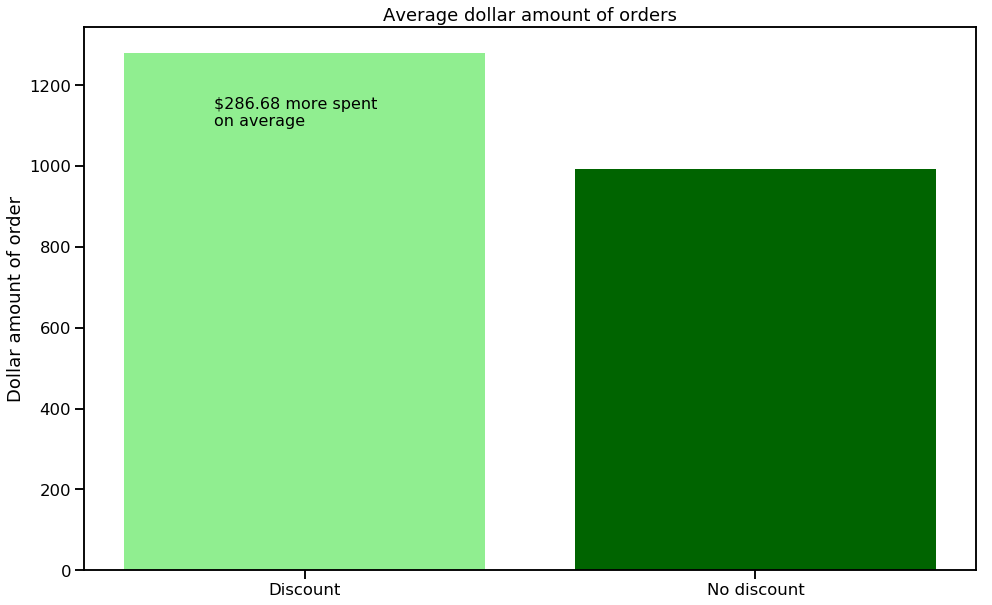

In [66]:
# Visualize raw effect size
x_values = ['Discount', 'No discount']
y_values = [np.mean(orders_disc_trimmed), np.mean(orders_no_disc_trimmed)]

plt.figure(figsize=(16,10))
plt.bar(x_values, y_values, color='darkgreen')
plt.bar(x_values[0], y_values[0], color='lightgreen')
plt.text(x=-0.2, y=1100, s='$286.68 more spent\non average', fontsize='16')
plt.ylabel('Dollar amount of order')
plt.title('Average dollar amount of orders')
plt.show();

## Hypothesis test 4

Is discounting effective in the most popular product category? 

A little exploration (below) shows that 'Beverages' is the most popular product category by quantities of products ordered and total revenues. For purchases of products in this category, do customers spend more when discounts are offered? If so, then the recommendations I made above regarding the discount structure should definitely be applied in this category, where they have the potential to have a big impact. If not, then it might be better to stop discounting Beverage products and focus our discounting strategy elsewhere. Again, without knowing the profit margins on individual products, it is impossible to say for sure how effective the discount strategy is, but I think this question is worth considering with the data that is available.

H<sub>0</sub>: mean `ProductTotal` for non-discounted beverages == mean `ProductTotal` for discounted beverages

H<sub>a</sub>: mean `ProductTotal` for non-discounted beverages < mean `ProductTotal` for discounted beverages

For this one-tailed Welch's t-test, I will continue to use the same alpha (0.05) and power (0.8) as before.

Let's return to our original dataset and see what we can learn about the Beverages category.

In [67]:
# Preview the DataFrame
df.head(10)

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryID,CategoryName,Discount_bool,ProductTotal
0,10248,11,14.0,12,0.00,Queso Cabrales,4,Dairy Products,0,168.00
1,10248,42,9.8,10,0.00,Singaporean Hokkien Fried Mee,5,Grains/Cereals,0,98.00
2,10248,72,34.8,5,0.00,Mozzarella di Giovanni,4,Dairy Products,0,174.00
3,10249,14,18.6,9,0.00,Tofu,7,Produce,0,167.40
4,10249,51,42.4,40,0.00,Manjimup Dried Apples,7,Produce,0,1696.00
5,10250,41,7.7,10,0.00,Jack's New England Clam Chowder,8,Seafood,0,77.00
6,10250,51,42.4,35,0.15,Manjimup Dried Apples,7,Produce,1,1261.40
7,10250,65,16.8,15,0.15,Louisiana Fiery Hot Pepper Sauce,2,Condiments,1,214.20
8,10251,22,16.8,6,0.05,Gustaf's Knäckebröd,5,Grains/Cereals,1,95.76
9,10251,57,15.6,15,0.05,Ravioli Angelo,5,Grains/Cereals,1,222.30


What is the most popular category by number of distinct products?

In [68]:
# Group by category, count distinct products
df.groupby('CategoryName')['ProductId'].nunique()

CategoryName
Beverages         12
Condiments        12
Confections       13
Dairy Products    10
Grains/Cereals     7
Meat/Poultry       6
Produce            5
Seafood           12
Name: ProductId, dtype: int64

Confections has the most unique products, followed by Beverages, Condiments, and Seafood.

Which category sells the most by volume?

In [69]:
# Group by category, sum the quantities
df.groupby('CategoryName')['Quantity'].sum()

CategoryName
Beverages         9532
Condiments        5298
Confections       7906
Dairy Products    9149
Grains/Cereals    4562
Meat/Poultry      4199
Produce           2990
Seafood           7681
Name: Quantity, dtype: int64

Beverages is the category that sells the most units.

Which category sells the most by total revenue?

In [70]:
df.groupby('CategoryName')['ProductTotal'].sum()

CategoryName
Beverages         267868.1800
Condiments        106047.0850
Confections       167357.2250
Dairy Products    234507.2850
Grains/Cereals     95744.5875
Meat/Poultry      163022.3595
Produce            99984.5800
Seafood           131261.7375
Name: ProductTotal, dtype: float64

The Beverages category has brought in the most revenue over the period covered by the dataset. This hypothesis test will focus on just the Beverages category.

### Prepare the data

I will need to subset the data to capture just observations from the Beverages category. Then I will split this data into discounted and non-discounted samples.

In [71]:
# Get just the Beverages data
bevs = df[df.CategoryName == 'Beverages']

In [72]:
# View summary statistics
bevs.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID,Discount_bool,ProductTotal
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.0,404.000000,404.000000
mean,10673.623762,40.485149,29.236757,23.594059,0.061881,1.0,0.391089,663.040050
std,247.990919,26.618382,55.596543,19.222830,0.088241,0.0,0.488599,1685.811331
min,10253.000000,1.000000,3.600000,2.000000,0.000000,1.0,0.000000,13.500000
25%,10464.750000,24.000000,11.200000,10.000000,0.000000,1.0,0.000000,108.000000
50%,10685.000000,38.000000,15.000000,20.000000,0.000000,1.0,0.000000,251.550000
75%,10885.000000,70.000000,18.000000,30.000000,0.150000,1.0,1.000000,504.000000
max,11077.000000,76.000000,263.500000,130.000000,0.250000,1.0,1.000000,15810.000000


### Inspect the distributions

Since my analysis will focus on `ProductTotal`, I should investigate the distribution of those values

<Figure size 1152x432 with 0 Axes>

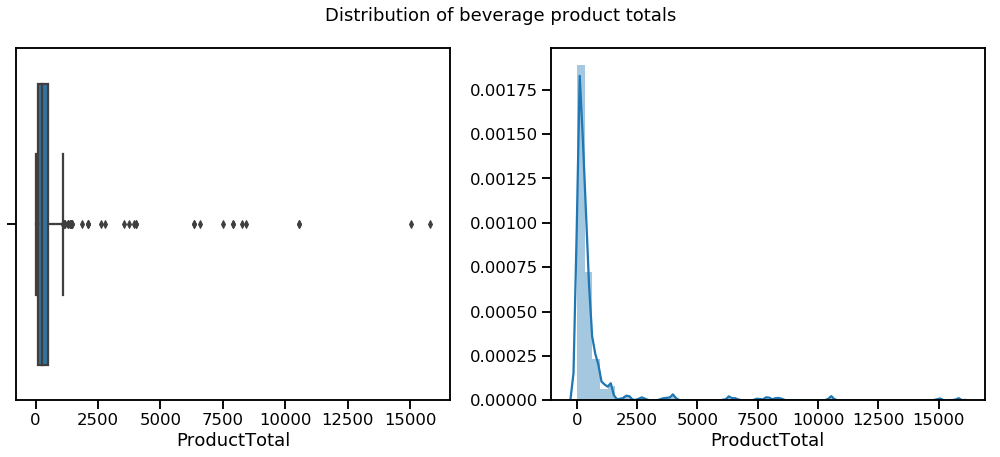

In [73]:
# Create boxplot and distplot for bevs.ProductTotal
plt.figure(figsize=(16,6))
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1 = sns.boxplot(bevs.ProductTotal, ax=axes[0])
ax2 = sns.distplot(bevs.ProductTotal, ax=axes[1])
plt.suptitle('Distribution of beverage product totals', y=1.05, fontsize=18)
plt.tight_layout()
plt.show();

Some extreme `ProductTotal` values are giving this distribution a pretty dramatic skew. I will trim it as I have done before, by removing values that are more than 1.5 times the interquartile range above the 75th percentile.

In [74]:
# Calculate the cutoff point (1.5*IQR + 75th percentile) for non-discounted
iqr = stats.iqr(bevs.ProductTotal)
upper_quartile = np.percentile(bevs.ProductTotal, 75)
cutoff = 1.5 * iqr + upper_quartile

# Remove outliers from non-discounted sample
bevs_trimmed = bevs[bevs.ProductTotal <= cutoff]
bevs_trimmed.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID,Discount_bool,ProductTotal
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.0,366.000000,366.000000
mean,10671.019126,40.639344,16.229645,21.530055,0.062158,1.0,0.382514,285.188648
std,247.870077,27.682465,20.170329,16.297337,0.088880,0.0,0.486666,234.071223
min,10253.000000,1.000000,3.600000,2.000000,0.000000,1.0,0.000000,13.500000
25%,10464.250000,24.000000,7.750000,10.000000,0.000000,1.0,0.000000,101.250000
50%,10671.500000,35.000000,15.000000,20.000000,0.000000,1.0,0.000000,216.000000
75%,10885.000000,70.000000,18.000000,30.000000,0.150000,1.0,1.000000,386.250000
max,11077.000000,76.000000,263.500000,120.000000,0.250000,1.0,1.000000,1080.000000


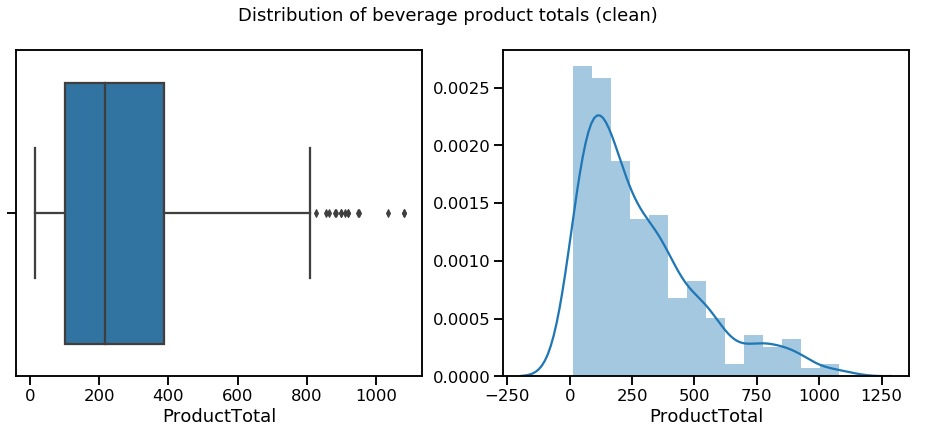

In [75]:
# Create boxplot and distplot for bevs.ProductTotal
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1 = sns.boxplot(bevs_trimmed.ProductTotal, ax=axes[0])
ax2 = sns.distplot(bevs_trimmed.ProductTotal, ax=axes[1])
plt.suptitle('Distribution of beverage product totals (clean)', fontsize=18)
plt.show();

That's much better. There is still a bit of skew to the right, but this is normal enough. 

Now I can split the data into discounted and non-discounted samples.

In [76]:
# Split the data into discounted/non-discounted samples
bevs_no_discount = bevs_trimmed[bevs_trimmed.Discount_bool == 0]
print('Non-discounted sample size:', len(bevs_no_discount))
bevs_discount = bevs_trimmed[bevs_trimmed.Discount_bool == 1]
print('Discounted sample size:', len(bevs_discount))

Non-discounted sample size: 226
Discounted sample size: 140


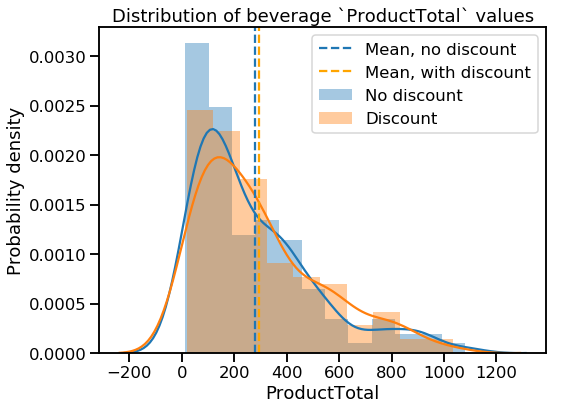

In [77]:
# Visualize the samples
plt.figure(figsize=(8,6))
sns.distplot(bevs_no_discount.ProductTotal, label='No discount')
sns.distplot(bevs_discount.ProductTotal, label='Discount')
plt.axvline(x=np.mean(bevs_no_discount.ProductTotal), linestyle='--',
            label='Mean, no discount')
plt.axvline(x=np.mean(bevs_discount.ProductTotal), linestyle='--', color='orange',
            label='Mean, with discount')
plt.legend()
plt.title('Distribution of beverage `ProductTotal` values')
plt.ylabel('Probability density')
plt.show();

In [78]:
# Compare sample variances (null hypothesis: they are equal)
stats.levene(bevs_no_discount.ProductTotal, bevs_discount.ProductTotal)

LeveneResult(statistic=0.07109017019934862, pvalue=0.7899070356247272)

The sample variances are equivalent, but they are different sizes. Time to move on to the Welch's t-test.

### Perform Welch's t-test

In [79]:
# Perform Welch's t-test and print results
run_welch(bevs_no_discount.ProductTotal, bevs_discount.ProductTotal)

Fail to reject null hypothesis (p_value = 0.23757564846540635)


The null hypothesis was that discounting has no effect on the mean `ProductValue` in the Beverages category, and we have failed to reject it. Discounting has no significant effect on how much customers spend on a beverage product when ordering. 

Let's calculate the power of our test to see our risk of Type II errors:

In [80]:
size_and_power(bevs_discount.ProductTotal, bevs_no_discount.ProductTotal)

Raw effect size: 18.003687420986125
Cohen's d: 0.07707473178493646
Power: 0.11387104912190102


Given the sizes of the two samples and the small effect size, the test has a very low power, far below my chosen threshold of 0.8. There is a very high risk that I may be making a Type II error here, saying that discount has no effect when it actually does. 

Based on this hypothesis test, I would recommend conducting further research to determine the effectiveness of discounting in the Beverages category before eliminating discounting in that category altogether.

# Interpretation and recommendations

Given the outcome of Hypothesis Test 1, **I recommend eliminating 10% discounts altogether** (or better yet, investigating why they might not be having the intended effect) **and perhaps eliminating some of the smaller discount levels to focus on the more effective 20% and 25% discount levels.** Without knowing the profit margins for each product, I can't determine the cost effectiveness of these discounts, but if the goal is to increase quantities ordered, these are the better levels to use.

Based on Hypothesis Test 2, I can say that **discounting correlates to a higher total quantity of items in an order.** If sales volume is an important metric, then discounting is a valid way to increase the overall volume of orders.

Test 3 showed that discounting also correlates to orders with higher dollar values. **Getting a discounted item into every shopping cart should be a priority** if the purpose of the discounting strategy is to raise overall order revenue. One way to do this may be to identify the most popular items and offer small discounts on them year-round.

Based on the final hypothesis test, **I recommend conducting further research to determine the effectiveness of discounting in the Beverages category** before eliminating discounting in that category altogether.

In the future, in addition to the research suggested above, it would be beneficial if possible to incorporate data on the costs or profit margins of all products so that the effects of discounting on profit (rather than volume or revenue) can be measured directly.